# **DATA3888 Project: Optiver**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler
import os
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## **1. Combining CSVs**

In [8]:
csv_files = sorted(glob("Data/individual_book_train/*.csv"))

ldf = pl.scan_csv(
    csv_files,
    schema_overrides={         
        'time_id': pl.Int64,
        'seconds_in_bucket': pl.Int64,
        'bid_price1': pl.Float64,
        'ask_price1': pl.Float64,
        'bid_price2': pl.Float64,
        'ask_price2': pl.Float64,
        'bid_size1': pl.Int64,
        'ask_size1': pl.Int64,
        'bid_size2': pl.Int64,
        'ask_size2': pl.Int64,
        'stock_id': pl.Int64,
    },
    infer_schema_length=0
)

# df = ldf.collect()  
# df.write_parquet("Data/Combined_book_train.parquet", compression="snappy")

In [ ]:
df = pl.read_parquet(
    "Data/Combined_book_train.parquet",
    use_pyarrow=True  
)

In [ ]:
df = df.to_pandas()

In [ ]:
df.shape[0]/857864

194.9648067758992

In [ ]:
window_size = 300   
df['window_start'] = (df['seconds_in_bucket'] // window_size) * window_size

agg = (
    df
    .groupby(['stock_id', 'time_id', 'window_start'], as_index=False)
    .agg({
        'bid_price1':  'mean',
        'ask_price1':  'mean',
        'bid_price2':  'mean',
        'ask_price2':  'mean',
        'bid_size1':   'sum',
        'ask_size1':   'sum',
        'bid_size2':   'sum',
        'ask_size2':   'sum',
    })
)

agg['seconds_in_bucket'] = agg['window_start']

In [ ]:
agg.shape[0]

857864

In [ ]:
agg["stock_id"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

In [ ]:
summary = (agg
    .groupby('stock_id')
    .agg(
        avg_bid_size1   = ('bid_size1', 'mean'),
        avg_ask_size1   = ('ask_size1', 'mean'),
        avg_bid_size2   = ('bid_size2', 'mean'),
        avg_ask_size2   = ('ask_size2', 'mean'),
        avg_bid_price1  = ('bid_price1','mean'),
        avg_ask_price1  = ('ask_price1','mean'),
    )
)

summary['spread']    = summary['avg_ask_price1'] - summary['avg_bid_price1']
summary['depth']     = summary[['avg_bid_size1','avg_ask_size1','avg_bid_size2','avg_ask_size2']].mean(axis=1)
summary['liq_score'] = summary['depth'] / summary['spread']

k = 30
top_liquid = summary.nlargest(k, 'liq_score').index.tolist()
print(top_liquid)

[32, 31, 77, 43, 29, 41, 108, 111, 47, 124, 46, 35, 119, 44, 125, 69, 21, 13, 86, 99, 63, 123, 14, 10, 120, 85, 105, 89, 74, 50]


In [ ]:
df1 = agg.copy()

df1['mid'] = (df1['bid_price1'] + df1['ask_price1']) / 2
df1 = df1.sort_values(['stock_id','time_id','seconds_in_bucket'])
df1['mid_prev'] = df1.groupby('stock_id')['mid'].shift(1)
df1['ret']     = np.log(df1['mid'] / df1['mid_prev'])

vol = df1.groupby('stock_id')['ret'].var().rename('ret_var')

threshold = vol.quantile(0.75)
high_vol = vol[vol > threshold].index.tolist()
print(high_vol)

[1, 3, 6, 8, 9, 11, 16, 18, 27, 31, 33, 44, 56, 62, 63, 74, 75, 80, 81, 83, 88, 89, 90, 94, 97, 100, 112, 124]


In [ ]:
summary = summary.join(vol)

X = StandardScaler().fit_transform(summary)
pca = PCA(n_components=2).fit(X)
scores = pca.transform(X)   

pc1_scores = pd.Series(np.abs(scores[:,0]), index=summary.index)
top_pca = pc1_scores.nlargest(30).index.tolist()
print(top_pca)

[31, 32, 77, 108, 41, 43, 29, 111, 47, 35, 37, 33, 98, 5, 103, 112, 18, 75, 4, 27, 30, 0, 88, 16, 62, 116, 113, 110, 126, 90]


In [ ]:
main_df = df[df['stock_id'].isin(top_pca)]

In [ ]:
main_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,window_start
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165425983,32767,575,1.000330,1.001253,1.000308,1.001319,90,76,23,153,98,300
165425984,32767,577,1.000330,1.001253,1.000308,1.001319,90,76,2,153,98,300
165425985,32767,581,1.000330,1.001253,1.000308,1.001319,90,91,2,153,98,300
165425986,32767,591,1.000330,1.001253,1.000308,1.001319,90,91,2,166,98,300


### **1.1 Pipeline**

In [23]:
def make_main_df(csvPath: str, keepData: bool = True) -> pd.DataFrame:
    # Step 1: Load CSV files
    csv_files = sorted(glob("/Users/tobitlouis/Desktop/Data/individual_book_train/*.csv"))
    csv_files = filter_valid_csvs(csv_files, expected_cols=11)


    # Define strict schema to avoid schema mismatch errors
    schema = {
        'time_id': pl.Int64,
        'seconds_in_bucket': pl.Int64,
        'bid_price1': pl.Float64,
        'ask_price1': pl.Float64,
        'bid_price2': pl.Float64,
        'ask_price2': pl.Float64,
        'bid_size1': pl.Int64,
        'ask_size1': pl.Int64,
        'bid_size2': pl.Int64,
        'ask_size2': pl.Int64,
        'stock_id': pl.Int64,
    }

    # Load lazily with strict schema and no inference
    ldf = pl.scan_csv(
        csv_files,
        schema=schema,
        skip_rows_after_header=0,
        infer_schema_length=None,
        has_header=True
    )

    # Collect into a single DataFrame
    df = ldf.collect()

    # Save to Parquet
    parquet_path = "combined_stock_data.parquet"
    df.write_parquet(parquet_path, compression="snappy")

    # Read from Parquet to pandas
    df = pl.read_parquet(parquet_path, use_pyarrow=True).to_pandas()

    # Optional: delete the Parquet after loading
    if not keepData and os.path.exists(parquet_path):
        os.remove(parquet_path)

    # Step 2: Reduce granularity into 5-min windows
    df['window_start'] = (df['seconds_in_bucket'] // 300) * 300

    agg = (
        df.groupby(['stock_id', 'time_id', 'window_start'], as_index=False)
          .agg({
              'bid_price1':  'mean',
              'ask_price1':  'mean',
              'bid_price2':  'mean',
              'ask_price2':  'mean',
              'bid_size1':   'sum',
              'ask_size1':   'sum',
              'bid_size2':   'sum',
              'ask_size2':   'sum',
          })
    )

    agg['seconds_in_bucket'] = agg['window_start']

    # Step 3: Stock selection via liquidity + volatility scoring
    df1 = agg.copy()
    df1['mid'] = (df1['bid_price1'] + df1['ask_price1']) / 2
    df1 = df1.sort_values(['stock_id', 'time_id', 'seconds_in_bucket'])
    df1['mid_prev'] = df1.groupby('stock_id')['mid'].shift(1)
    df1['ret'] = np.log(df1['mid'] / df1['mid_prev'])

    # Summary stats
    summary = agg.groupby('stock_id').agg(
        avg_bid_size1=('bid_size1', 'mean'),
        avg_ask_size1=('ask_size1', 'mean'),
        avg_bid_size2=('bid_size2', 'mean'),
        avg_ask_size2=('ask_size2', 'mean'),
        avg_bid_price1=('bid_price1', 'mean'),
        avg_ask_price1=('ask_price1', 'mean'),
    )

    summary['spread'] = summary['avg_ask_price1'] - summary['avg_bid_price1']
    summary['depth'] = summary[
        ['avg_bid_size1', 'avg_ask_size1', 'avg_bid_size2', 'avg_ask_size2']
    ].mean(axis=1)
    summary['liq_score'] = summary['depth'] / summary['spread']

    # Volatility as return variance
    vol = df1.groupby('stock_id')['ret'].var().rename('ret_var')
    summary = summary.join(vol)

    # PCA-based stock ranking
    X = StandardScaler().fit_transform(summary)
    pca = PCA(n_components=2).fit(X)
    scores = pca.transform(X)
    pc1_scores = pd.Series(np.abs(scores[:, 0]), index=summary.index)
    top_pca = pc1_scores.nlargest(30).index.tolist()

    # Filter original data for selected stocks
    return df[df['stock_id'].isin(top_pca)]

In [ ]:
mainDF = make_main_df("/Users/tobitlouis/Downloads/*.csv", keepData = True)


In [ ]:
import pandas as pd
from glob import glob

def filter_valid_csvs(file_paths, expected_cols=11):
    valid_files = []
    for path in file_paths:
        try:
            df_sample = pd.read_csv(path, nrows=1)
            if df_sample.shape[1] == expected_cols:
                valid_files.append(path)
        except Exception as e:
            print(f"Skipping {path} due to read error: {e}")
    return valid_files

filter_valid_csvs(
    glob("/Users/tobitlouis/Downloads/*.csv"),
    expected_cols=11
)

## **2. Feature Engineering**

In [22]:
mainDF = pd.read_parquet("Data/combined.parquet")

In [24]:
mainDF.drop("window_start",axis=1, inplace=True)

In [ ]:
mainDF.info()

In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [ ]:
df = make_features(mainDF)

In [28]:
df.to_parquet("Final.parquet")

## **3. Model Testing**

In [ ]:
df = pd.read_parquet("Data/Final.parquet")

In [ ]:
uids = df['time_id'].unique()
cut  = int(0.8 * len(uids))
train_ids, val_ids = uids[:cut], uids[cut:]
train_df = df[df.time_id.isin(train_ids)]
val_df   = df[df.time_id.isin(val_ids)]

In [ ]:
y_train_log = np.log1p(train_df['realized_volatility'].values)
y_val_log   = np.log1p(val_df  ['realized_volatility'].values)

In [ ]:
ID_COLS = ['stock_id', 'time_id', 'seconds_in_bucket']
X_train = train_df.drop(columns=['realized_volatility'] + ID_COLS)
X_val   = val_df  .drop(columns=['realized_volatility'] + ID_COLS)

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train_log)
val_data   = lgb.Dataset(X_val,   label=y_val_log)

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_jobs': -1,
    'boosting_type': 'gbdt',
    'verbosity': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=100)
    ],
    num_boost_round=1000
)

Training until validation scores don't improve for 20 rounds
[100]	valid_0's rmse: 0.00572722
[200]	valid_0's rmse: 0.00571711
[300]	valid_0's rmse: 0.00571258
[400]	valid_0's rmse: 0.0057102
Early stopping, best iteration is:
[412]	valid_0's rmse: 0.00570979


In [ ]:
y_pred_log = model.predict(X_val, num_iteration=model.best_iteration)
y_pred      = np.expm1(y_pred_log)             
y_true      = val_df['realized_volatility'].values

Validation RMSE: 0.0057097914
Mean target: 0.2359548412152119
Std of target: 0.9542211994154018
Relative RMSE: 0.024198661760177254


In [ ]:
rmse = root_mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"RMSE (original scale): {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"R²   : {r2:.4f}")

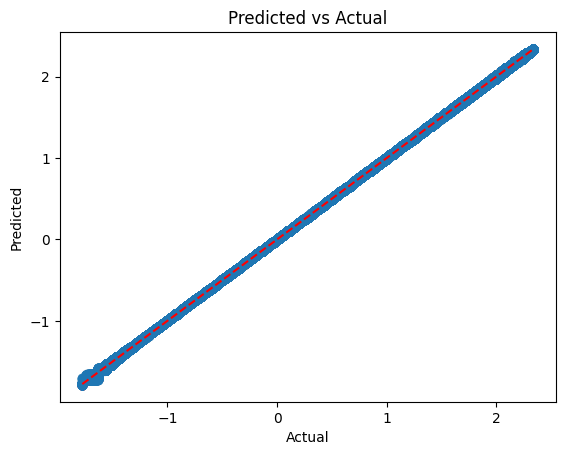

In [ ]:
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    'r--',
    linewidth=1
)
plt.xlabel('Actual Realized Volatility')
plt.ylabel('Predicted Realized Volatility')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()


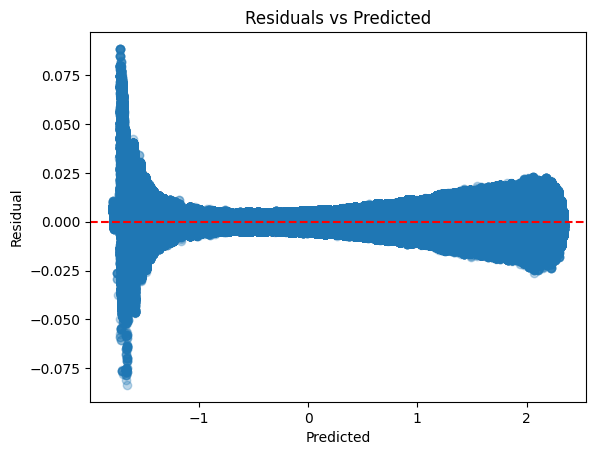

In [ ]:
residuals = y_true - y_pred
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Realized Volatility')
plt.ylabel('Residual (Actual − Predicted)')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()